In [6]:
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,auc,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from textblob import TextBlob
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
tqdm.pandas()

In [13]:
df2 = pd.read_csv('C:/Users/samarth152721/Downloads/complaints.csv')
df = df2[['Product','Consumer complaint narrative']]
df.head()

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",NaN
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
3,Debt collection,"Over the past 2 weeks, I have been receiving e..."
4,Vehicle loan or lease,NaN


In [14]:
df.isna().sum()

Product                               0
Consumer complaint narrative    1014876
dtype: int64

In [15]:
df.shape

(1511595, 2)

In [16]:
df.dropna(inplace = True)
df.reset_index(drop=True,inplace=True)

In [17]:
df.shape

(496719, 2)

In [7]:
#Counter(word_tokenize(' '.join(df['Consumer complaint narrative'].values)))

In [8]:
all_text = ' '.join(df['Consumer complaint narrative'].values)

In [9]:
all_text[:100]

'transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate. I'

In [10]:
all_text.count('Transworld')

1560

In [18]:
df.reset_index(drop=True,inplace=True)
a =df['Consumer complaint narrative'][3]
a

'someone used my personal information to get medical treatment that i did not authorize.i have filed a report i have tried to dispute these 2 accounts and nothing gets resolved.'

In [19]:
def removal(text):
    text = re.sub('XXXX',' UNKNOWN ',text)
    text = re.sub('XX/XX/','',text)
    text = re.sub('UNKNOWN   UNKNOWN','UNKNOWN',text)
    text = re.sub('\n',' ',text)
    text = re.sub('  ',' ',text)
    return text

In [20]:
df['Product'].unique()

array(['Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Money transfer, virtual currency, or money service',
       'Credit card or prepaid card', 'Mortgage', 'Student loan',
       'Checking or savings account',
       'Payday loan, title loan, or personal loan',
       'Vehicle loan or lease', 'Credit card', 'Consumer Loan',
       'Payday loan', 'Bank account or service', 'Credit reporting',
       'Prepaid card', 'Other financial service', 'Money transfers',
       'Virtual currency'], dtype=object)

In [21]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    147298
Debt collection                                                                 107741
Mortgage                                                                         61901
Credit card or prepaid card                                                      32643
Credit reporting                                                                 31588
Student loan                                                                     25186
Checking or savings account                                                      19418
Credit card                                                                      18838
Bank account or service                                                          14885
Consumer Loan                                                                     9473
Vehicle loan or lease                                                             8283
Money transfer, virtual currency, or money 

In [22]:
stop_words = list(set(stopwords.words('english')))+list(punctuation)
lem = WordNetLemmatizer()

In [23]:
def cleaning(text):
    text = removal(text)
    text = text.lower()
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    #words = [w for w in words if len(w)>2]
    words = [lem.lemmatize(w) for w in words]
    return ' '.join(words)

In [24]:
df['Clean Text'] = df['Consumer complaint narrative'].progress_apply(cleaning)

 57%|█████████████████████████████████████████▎                               | 281195/496719 [10:53<07:39, 468.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████████████████████████████| 496719/496719 [19:23<00:00, 426.96it/s]


In [25]:
df1 = df[['Product','Consumer complaint narrative','Clean Text']]

In [26]:
df1.head()

,Product,Consumer complaint narrative,Clean Text
0,Debt collection,transworld systems inc. \nis trying to collect...,transworld system inc. trying collect debt min...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,would like request suppression following item ...
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",past 2 week receiving excessive amount telepho...
3,"Credit reporting, credit repair services, or o...",someone used my personal information to get me...,someone used personal information get medical ...
4,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",sold access event digitally screenshots detail...


In [27]:
df1['Clean Text'][0]

'transworld system inc. trying collect debt mine owed inaccurate'

In [28]:
df1['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    147298
Debt collection                                                                 107741
Mortgage                                                                         61901
Credit card or prepaid card                                                      32643
Credit reporting                                                                 31588
Student loan                                                                     25186
Checking or savings account                                                      19418
Credit card                                                                      18838
Bank account or service                                                          14885
Consumer Loan                                                                     9473
Vehicle loan or lease                                                             8283
Money transfer, virtual currency, or money 

In [29]:
def renaming(text):
    if text =='Prepaid card':
        return 'Credit card or prepaid card'
    elif text == 'Payday loan':
        return 'Loans'
    elif text == 'Credit reporting':
        return 'Credit reporting, credit repair services, or other personal consumer reports'
    elif text == 'Money transfers':
        return 'Money transfer, virtual currency, or money service'
    elif text == 'Credit card':
        return 'Credit card or prepaid card'
    elif text == 'Consumer Loan':
        return 'Loans'
    elif text == 'Vehicle loan or lease':
        return 'Loans'
    elif text == 'Payday loan, title loan, or personal loan':
        return 'Loans'
    elif text == 'Student loan':
        return 'Loans'
    elif text == 'Virtual currency':
        return 'Money transfer, virtual currency, or money service'
    else:
        return text

In [30]:
df1['Product'] = df1['Product'].progress_apply(renaming)

100%|██████████████████████████████████████████████████████████████████████| 496719/496719 [00:00<00:00, 836640.51it/s]


In [31]:
df1.head()

,Product,Consumer complaint narrative,Clean Text
0,Debt collection,transworld systems inc. \nis trying to collect...,transworld system inc. trying collect debt min...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,would like request suppression following item ...
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",past 2 week receiving excessive amount telepho...
3,"Credit reporting, credit repair services, or o...",someone used my personal information to get me...,someone used personal information get medical ...
4,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",sold access event digitally screenshots detail...


In [32]:
df1['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    178886
Debt collection                                                                 107741
Mortgage                                                                         61901
Credit card or prepaid card                                                      52931
Loans                                                                            51189
Checking or savings account                                                      19418
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                                9476
Other financial service                                                            292
Name: Product, dtype: int64

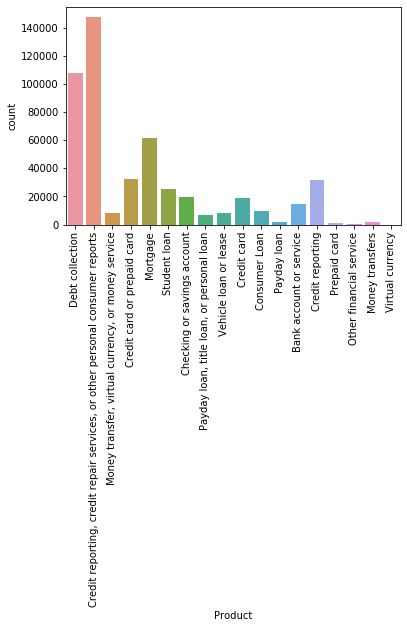

In [33]:
chart = sns.countplot(df['Product'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

In [26]:
x = df1['Clean Text']
y = df1['Product']

In [27]:
tfidf = TfidfVectorizer()
x1 = tfidf.fit_transform(x)

In [28]:
x_train,x_test,y_train,y_test = train_test_split(x1,y,test_size = 0.2,random_state = 42)

In [29]:
random = RandomForestClassifier(n_estimators=100,max_depth=300,class_weight = 'balanced')

In [ ]:
random.fit(x_train,y_train)

In [ ]:
predict = random.predict(x_test)

In [ ]:
print(classification_report(y_test,predict))

In [ ]:
accuracy_score(y_test,predict)  #74.080

In [ ]:
df1.shape

In [ ]:
nav_bia = MultinomialNB()

In [ ]:
nav_bia.fit(x_train,y_train)

In [ ]:
predictions = nav_bia.predict(x_test)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
df1.reset_index(drop =True,inplace = True)

In [ ]:
accuracy_score(y_test,predictions)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
senti = SentimentIntensityAnalyzer()

In [ ]:
df['Vader Score'] = ' '

In [ ]:
senti.polarity_scores(df['Consumer complaint narrative'][0])

In [ ]:
df1['Clean Text'][12]

In [ ]:
df['Consumer complaint narrative'][20]

In [ ]:
sentiment = []
for i in tqdm(range(len(df))):
    sentiment.append(TextBlob(df['Consumer complaint narrative'][i]).sentiment[0])

In [ ]:
df['Sentiment'] = sentiment
df.head(50)

In [ ]:
df.sort_values(by=['Sentiment'])

In [ ]:
df['Consumer complaint narrative'][124101]

In [ ]:
df['Clean Text'][257114]

In [ ]:
blob = TextBlob(df['Consumer complaint narrative'][3])

In [ ]:
print(blob.sentiment[0])

In [ ]:
df['Consumer complaint narrative'][3]

In [ ]:
all_text = ' '.join(df1['Clean Text'].values)

In [49]:
all_text.count('loan')

390352

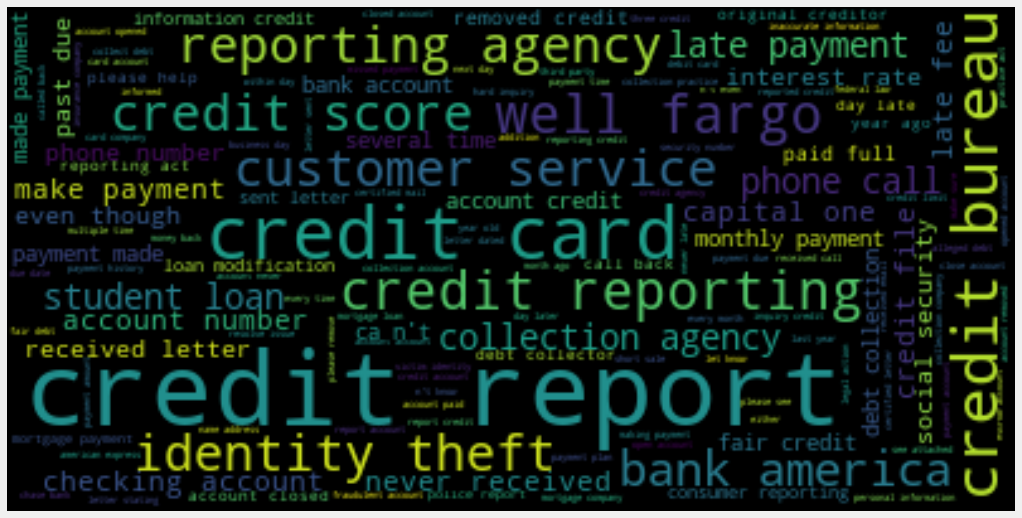

In [34]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

%matplotlib inline
text = ' '.join(df1['Clean Text'].values)

STOPWORDS = set(list(STOPWORDS)+['unknown'])

wordcloud = WordCloud(stopwords=STOPWORDS).generate(str(' '.join(df1['Clean Text'])))

fig = plt.figure(
    figsize = (14, 10),
    facecolor = '#F0F0F0',
    edgecolor = '#F0F0F0')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [35]:
df3 = df1[df1['Product']=='Credit card or prepaid card']

In [40]:
df2.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,HYUNDAI CAPITAL AMERICA,FL,33161,NaN,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,NaN,3146310


In [36]:
df3.head()

,Product,Consumer complaint narrative,Clean Text
6,Credit card or prepaid card,On XX/XX/2018 I made a {$87.00} purchase with ...,2018 made 87.00 purchase suntrust reward credi...
72,Credit card or prepaid card,"On XX/XX/XXXX, Bank of America mailed out a ca...",unknown bank america mailed card new authorize...
84,Credit card or prepaid card,"On XX/XX/XXXX, I purchased two {$500.00} visa ...",unknown purchased two 500.00 visa gift card un...
88,Credit card or prepaid card,"Dear Consumer Financial Protection Bureau, Syn...",dear consumer financial protection bureau sync...
96,Credit card or prepaid card,I was stupid enough to charge some items at MA...,stupid enough charge item macy 's macy 's cred...


In [ ]:
  precision    recall  f1-score   support

                                                     Bank account or service       0.34      0.22      0.27      3025
                                                 Checking or savings account       0.44      0.35      0.39      3830
                                                 Credit card or prepaid card       0.63      0.64      0.64     10605
Credit reporting, credit repair services, or other personal consumer reports       0.78      0.93      0.85     35614
                                                             Debt collection       0.75      0.75      0.75     21647
                                                                       Loans       0.73      0.53      0.62     10259
                          Money transfer, virtual currency, or money service       0.76      0.27      0.40      1936
                                                                    Mortgage       0.83      0.76      0.79     12376
                                                     Other financial service       1.00      0.06      0.11        52

                                                                    accuracy                           0.74     99344
                                                                   macro avg       0.70      0.50      0.54     99344
                                                                weighted avg       0.73      0.74      0.73     99344

In [ ]:
precision    recall  f1-score   support

                                                     Bank account or service       0.66      0.16      0.26      3025
                                                 Checking or savings account       0.58      0.53      0.56      3830
                                                 Credit card or prepaid card       0.75      0.76      0.76     10605
Credit reporting, credit repair services, or other personal consumer reports       0.83      0.95      0.88     35614
                                                             Debt collection       0.83      0.83      0.83     21647
                                                                       Loans       0.87      0.68      0.77     10259
                          Money transfer, virtual currency, or money service       0.89      0.53      0.67      1936
                                                                    Mortgage       0.89      0.91      0.90     12376
                                                     Other financial service       1.00      0.06      0.11        52

                                                                    accuracy                           0.82     99344
                                                                   macro avg       0.81      0.60      0.64     99344
                                                                weighted avg       0.82      0.82      0.81     99344

I traded in a vehicle to the dealership on XXXX/XXXX/XXXX so the co-signer on vehicle could obtain a vehicle in his name alone. I was not purchasing another vehicle at the dealership. I was told that the dealership would pay off the full amount owed to PNC bank within 14 days. I followed up with PNC bank on receipt of payoff. The vehicle was paid off in full on XXXX/XXXX/XXXX. I received documentation that the account was closed on XXXX/XXXX/XXXX from a local PNC branch. I also received a letter dated XXXX/XXXX/XXXX from the bank that the loan was paid off and they even refunded {$14.00} of a over payment. The account was updated on my credit report as paid off. On XXXX/XXXX/XXXX I became aware that the account was reopened. I was told by the bank that they " reversed '' my account on XXXX/XXXX/XXXX. The bank stated that the dealership told them it was paid off in error and they mailed a check back to the dealership. The vehicle was not paid off in error and I have a signed agreement with the dealership that they took ownership of the vehicle and it would be paid off in full. I have talked to XXXX different people at the bank who could not give me any answers as to why, 2 months after my loan was closed, the dealership was able to do this. They could not give me answers on how it was possible for someone else to reopen my paid off loan and who at the bank allowed this to occur. The account is still open while they investigate and they have not allowed me to report the account to their fraud department.

In [41]:
df.shape

(496719, 3)

In [42]:
#df.to_csv('Clean_Complaints_Analysis.csv',index = False)

In [43]:
df3.head()

,Product,Consumer complaint narrative,Clean Text
6,Credit card or prepaid card,On XX/XX/2018 I made a {$87.00} purchase with ...,2018 made 87.00 purchase suntrust reward credi...
72,Credit card or prepaid card,"On XX/XX/XXXX, Bank of America mailed out a ca...",unknown bank america mailed card new authorize...
84,Credit card or prepaid card,"On XX/XX/XXXX, I purchased two {$500.00} visa ...",unknown purchased two 500.00 visa gift card un...
88,Credit card or prepaid card,"Dear Consumer Financial Protection Bureau, Syn...",dear consumer financial protection bureau sync...
96,Credit card or prepaid card,I was stupid enough to charge some items at MA...,stupid enough charge item macy 's macy 's cred...
